In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import random



In [273]:


def election_result_collection(data, json):

    planId = []
    democratsPercentage = []
    republicanPercentage = []
    total_plans = len(json.get("barData", []))
    
    for item in data:
        #total_district = len(item.get("ids",{}))
        total_district = json["totalDistricts"]
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        avg_dem_share = []
        avg_rep_share = []
        dem_seats = 0
        rep_seats = 0

        for district_id in dem_totals:
            #total votes (dem and rep) from the same disctrict (inside the district plan)
  
            total_votes = dem_totals[district_id] + rep_totals.get(district_id, 0)

            if total_votes > 0:
                dem_percentage = dem_totals[district_id] / total_votes * 100
                rep_percentage = rep_totals.get(district_id, 0) / total_votes * 100
            else:
                dem_percentage = 0
                rep_percentage = 0

            avg_dem_share.append(dem_percentage)
            avg_rep_share.append(rep_percentage)

            if dem_percentage > rep_percentage:
                dem_seats += 1
            elif rep_percentage > dem_percentage:
                rep_seats += 1


        total_plans+=1
        planId.append(total_plans)
        dem_share = round(np.mean(avg_dem_share)/100, 2)
        rep_share = round(np.mean(avg_rep_share)/100,2)
        democratsPercentage.append(dem_share)
        republicanPercentage.append(rep_share)
        json["totalDistricts"] = total_district
        json["democratAvgVoteShare"] = (
            json["democratAvgVoteShare"] * (total_plans - 1) + dem_share
        ) / total_plans
        json["republicanAvgVoteShare"] = (
            json["republicanAvgVoteShare"] * (total_plans - 1) + rep_share
        ) / total_plans
        json["democratAvgSeatShare"] = (
            json["democratAvgSeatShare"] * (total_plans - 1) + dem_seats / len(dem_totals)
        ) / total_plans
        json["republicanAvgSeatShare"] = (
            json["republicanAvgSeatShare"] * (total_plans - 1) + rep_seats / len(rep_totals)
        ) / total_plans

 

        
        
      
    ensembles = [ {"planId": v1, "democratsPercentage":v2, "republicanPercentage": v3  }
                for v1 ,v2, v3 in zip(planId, democratsPercentage, republicanPercentage)]
    json["barData"].extend(ensembles) 
def calculate_opportunity(data, json, minority='hispanic',opportunity_threshold=0):

    results = []

    for district_plan in data['barData']:
        plan_id = district_plan['planId']
        opportunity_districts = 0

        for district in district_plan['districts']:
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic'] + district['other']
            minoirty_population = district[minority]

            minority_proportion = minoirty_population / total_population 
            
            
            
            if minority_proportion >= opportunity_threshold:
                opportunity_districts += 1
            

        for plan in json['barData']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = opportunity_districts  # SMD: 1 rep per district
                plan['opportunityDistricts'] = opportunity_districts
                
                break
    return results
def collect_ensemble_demographic(data,shapefile ,json):
    if json["fips"] == "CO":
        hsp = "LAT"
    else:
        hsp = "HPAC"
    i = len(json.get("barData", []))
    planId = []
    white = []
    black = []
    asian = []
    hispanic = []
    other = []
    for item in data:
    
        districts =  item.get("ids", {})
        demo_summary= {
                    "white": 0,
                    "black": 0,
                    "asian": 0,
                    "hispanic": 0,
                    "other": 0
            }
        for district_id, precinct_ids  in districts.items():
       
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row[hsp]
                demo_summary["other"] += row["OTHR"]
        i+=1
        planId.append(i)
        white.append(demo_summary["white"])
        black.append(demo_summary["black"])
        asian.append(demo_summary["asian"])
        hispanic.append(demo_summary["hispanic"])
        other.append(demo_summary["other"])

    ensembles = [ {"planId": v1, "white":v2, "black": v3, "asian": v4, "hispanic": v5, "other": v6  }
                for v1 ,v2, v3, v4, v5, v6 in zip(planId, white, black, asian, hispanic, other)]
    
    json["barData"].extend(ensembles)                 
def collect_district_plan_demographic(data, shapefile, json):

    i = len(json.get("barData", []))  # Start planId based on existing data

    for item in data:
        districts = item.get("ids", {})
        district_demographics = []

        for district_id, precinct_ids in districts.items():
            
            demo_summary = {
                "districtId": district_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0,
                "other": 0
            }

            
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row['LAT']
                demo_summary["other"] += (
                    (row["OTHR"] + row["AIAN"] + row["HPAC"]) if json["fips"] == "NV" 
                    else (row["OTHR"] ))
                

  
              

          
            district_demographics.append(demo_summary)

        
        i += 1
        json["barData"].append({
            "planId": i,
            "districts": district_demographics
        })
   
def collect_vote_seat_share_metrics(data, json):
    planId = []
    demVoteShare = []
    demSeatShare = []
    repSeatShare = []
    repVoteShare = []
    total_plans = len(json.get("barData", []))

    for item in data:
        total_districts = len(item.get("elec_res", {}).get("percents_for_party", {}).get("Democratic", {}))
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        dem_seats = 0
        rep_seats = 0

        dem_vote_shares = []
        rep_vote_shares = []

        for district_id in dem_totals:
            dem_vote_share = dem_totals[district_id]
            rep_vote_share = rep_totals.get(district_id, 0)

            dem_vote_shares.append(dem_vote_share)
            rep_vote_shares.append(rep_vote_share)

            if dem_vote_share > rep_vote_share:
                dem_seats += 1
            elif rep_vote_share > dem_vote_share:
                rep_seats += 1

        avg_dem_vote_share = round(sum(dem_vote_shares) / total_districts, 2)
        avg_rep_vote_share = round(sum(rep_vote_shares) / total_districts, 2)
        dem_seat_share = round(dem_seats / total_districts, 2)
        rep_seat_share = round(rep_seats / total_districts, 2)

        
        total_plans += 1
        planId.append(total_plans)
        demVoteShare.append(avg_dem_vote_share)
        repVoteShare.append(avg_rep_vote_share)
        demSeatShare.append(dem_seat_share)
        repSeatShare.append(rep_seat_share)


    ensembles = [ 
                {"planId": v1,
                "demVoteShare":v2,
                "demSeatShare": v3 ,
                "repVoteShare": v4, 
                "repSeatShare": v5  }
                for v1 ,v2, v3 , v4,v5 in zip(planId, demVoteShare , demSeatShare, repVoteShare, repSeatShare)]

    json["barData"].extend(ensembles) 
def calculate_annotation_for_vote_seat_share(data): 
    bias = 0
    symmetry = 0
    responsiveness = 0

    dem_vote_share = np.array([entry['demVoteShare'] for entry in data['curveData']])
    rep_vote_share = np.array([entry['repVoteShare'] for entry in data['curveData']])
    total_districts = data['totalDistricts']
    
    # Calculate Democratic seat share cumulatively
    dem_seat_share = np.array([1 if vote > 0.5 else 0 for vote in dem_vote_share]).cumsum() / total_districts
    
    # Partisan Bias: Difference between seat share at 50% vote and 50%
    closest_to_50_index = np.argmin(np.abs(dem_vote_share - 0.5))
    bias = dem_seat_share[closest_to_50_index] - 0.5

    # Responsiveness: Average slope of the seats-votes curve in 45%-55% range
    in_range_indices = np.where((dem_vote_share >= 0.45) & (dem_vote_share <= 0.55))[0]
    slopes = []
    for i in range(len(in_range_indices) - 1):
        delta_vote = dem_vote_share[in_range_indices[i + 1]] - dem_vote_share[in_range_indices[i]]
        delta_seat = dem_seat_share[in_range_indices[i + 1]] - dem_seat_share[in_range_indices[i]]
        if delta_vote > 0:  # Avoid division by zero
            slopes.append(delta_seat / delta_vote)
    responsiveness = np.mean(slopes) if slopes else 0

    # Partisan Symmetry: Difference in seat shares at symmetric vote shares
    symmetry_differences = []
    for i, dem_vote in enumerate(dem_vote_share):
        symmetric_vote = 1 - dem_vote
        closest_symmetric_index = np.argmin(np.abs(dem_vote_share - symmetric_vote))
        if abs(dem_vote_share[closest_symmetric_index] - symmetric_vote) < 0.05:  # 5% tolerance
            sym_diff = dem_seat_share[i] - dem_seat_share[closest_symmetric_index]
            symmetry_differences.append(sym_diff)
    symmetry = np.mean(symmetry_differences) if symmetry_differences else 0

    
    data["bias"] = round(bias, 4)
    data["responsiveness"] = round(responsiveness, 4)
    data["symmetry"] = round(symmetry, 4)

    return data   
def collect_box_and_whisker_bins(data, json, races):

    total_bins = data["totalDistricts"]  # Total bins = total districts per plan

    
    bins_dict = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}
    enacted_bins = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}

    # Step 1: Process each district plan
    for plan_index, plan in enumerate(data["barData"]):  
        # Step 2: Extract and sort race percentages within each district plan
        race_percentages = {race: [] for race in races}
        for district in plan["districts"]:  
            total_population = sum(district[race] for race in races)
            for race in races:
                percentage = (district[race] / total_population) * 100 if total_population > 0 else 0
                race_percentages[race].append(percentage)
        
        # Sort percentages for each race and distribute them into bins
        for race in races:
            sorted_percentages = sorted(race_percentages[race])
            for i, value in enumerate(sorted_percentages):
                bin_key = f"Bin {i + 1}"
                bins_dict[bin_key][race].append(value)
        
        # Step 3: Process enacted plan separately (first plan only)
        if plan_index == 0:  
            for race in races:
                sorted_enacted = sorted(race_percentages[race])
                for i, value in enumerate(sorted_enacted):
                    bin_key = f"Bin {i + 1}"
                    enacted_bins[bin_key][race].append(value)

    # Step 4: Calculate statistics for each bin
    json["boxes"] = []
    for bin_key, race_data in bins_dict.items():
        stats = {"binNo": bin_key}
        for race, values in race_data.items():
            enacted_values = enacted_bins[bin_key][race]  # Enacted values for this bin and race
            values = np.array(values)
            if len(values) > 0:
                stats[race] = {
                    "min": float(np.min(values)),
                    "q1": float(np.percentile(values, 25)),
                    "median": float(np.median(values)),
                    "q3": float(np.percentile(values, 75)),
                    "max": float(np.max(values)),
                    "enactedValue": round(float(np.mean(enacted_values)), 2) if len(enacted_values) > 0 else 0
                }
            else:
                stats[race] = {"min": 0, "q1": 0, "median": 0, "q3": 0, "max": 0, "enactedValue": 0}
        json["boxes"].append(stats)
        json['totalDistricts'] = data["totalDistricts"]
def collec_metrics_plan_specific(data, json, plan_type):
    districtId = []
    democratsPercentage = []
    republicanPercentage = []
    opportunityThreshold = []
    isOpportunityDistrict = []
    white = []
    black = []
    asian = []
    hispanic = []
    other = []
    dem_votes = 0
    rep_votes = 0
    total_votes = []
    
    for item in data["features"]:
        districts = item["properties"]
        demographics =  districts["demographics"]
        demographic = districts.get("demographics", {})
        total_population = sum(demographic.values())
        districtId.append(districts.get("DISTRICTNO", None))
        democratsPercentage.append(districts.get("demRatio", 0))
        #republicanPercentage.append(districts.get("repRatio", 0))
        republicanPercentage.append(abs(1 - districts.get("demRatio" , 0)))
        opportunityThreshold.append(districts.get("oppThreshold", 0))
        isOpportunityDistrict.append(districts.get("oppDistrict", False))
        white.append(demographics.get("white", 0))
        black.append(demographics.get("black", 0))
        asian.append(demographics.get("asian", 0))
        hispanic.append(demographics.get("latin", 0))
        other.append(demographics.get("other", 0))
        total_votes.append(total_population)
        dem_votes += (total_population) * districts.get("demRatio", 0)
        rep_votes += (total_population) * (1 - districts.get("demRatio", 0))
    
   
    district_metrics = [
        {
            "districtId": dId,
            "democratsPercentage": dPct,
            "republicanPercentage": rPct,
            "opportunityThreshold": oThresh,
            "isOpportunityDistrict": isOpp,
            "white": w,
            "black": b,
            "asian": a,
            "hispanic": h,
            "other": o,
            "totalVotes": votes
        }
        for dId, dPct, rPct, oThresh, isOpp, w, b, a, h , o, votes, in zip(
            districtId, democratsPercentage, republicanPercentage,
            opportunityThreshold, isOpportunityDistrict,
            white, black, asian, hispanic,other, total_votes
        )
    ]

    json["districts"].extend(district_metrics)
    json["demTotalVotes"] = round(dem_votes)
    json["repTotalVotes"] = round(rep_votes)
    #json["planType"] = plan_type
def vote_seat_share_data_collectiotion_specific_plan(data ,json, planType ):

    districts = data["districts"]
    total_districts = data["totalDistricts"]
    curve_data = []
    dem_seats = 0
    rep_seats = 0


        

    for district in districts:
        dem_vote_share = district["democratsPercentage"]
        rep_vote_share = district["republicanPercentage"]

        
        if dem_vote_share > rep_vote_share:
            dem_seats +=1
        elif rep_vote_share > dem_vote_share:
            rep_seats +=1
   
        #dem_seat_share = round(dem_seats/ total_districts , 2)
        #rep_seat_share = round(rep_seats/ total_districts , 2)
            #"demSeatShare": dem_seat_share, "repSeatShare": rep_seat_share
 
        curve_data.append({
            "districtId": district["districtId"],
            "demVoteShare": dem_vote_share,
            "repVoteShare": rep_vote_share,
            "totalVotes": district["totalVotes"]
        
            
            
        })

    json["curveData"] = curve_data
    json["totalDistricts"] = len(districts)
    json["repTotalVotes"]= data["demTotalVotes"]
    json["demTotalVotes"]= data["repTotalVotes"]
    json["democratsSeats"]= dem_seats
    json["republicanSeats"]= rep_seats
def collect_result_collection_mmd(data, json):
    planId = []
    democratsPercentage = []
    republicanPercentage = []
    total_plans = len(json.get("barData", []))
    
    for item in data:
        # Initialize variables for the current plan
        total_districts = len(item.get("ids", {}))  # Total MMDs in this plan
        fra_res = item.get("fra_res", [])  # Vote results per district
        district_groupings = item.get("ids", {})  # MMD groupings 

        avg_dem_share = []
        avg_rep_share = []
        dem_seats = 0
        rep_seats = 0

        # Process each MMD (big district) by aggregating sub-district results
        for mmd_id, sub_districts in district_groupings.items():
            total_dem_votes = 0
            total_rep_votes = 0

            # Sum votes for all sub-districts in this MMD
            for sub_district in sub_districts:
                for district_results in fra_res:
                    for key, votes in district_results.items():
                        if int(key[1:]) == sub_district:  # Match sub-district number
                            if key.startswith("D"):
                                total_dem_votes += votes
                            elif key.startswith("R"):
                                total_rep_votes += votes

            # Calculate vote shares for the MMD
            total_votes = total_dem_votes + total_rep_votes
            if total_votes > 0:
                dem_percentage = (total_dem_votes / total_votes) * 100
                rep_percentage = (total_rep_votes / total_votes) * 100
            else:
                dem_percentage = 0
                rep_percentage = 0

            avg_dem_share.append(dem_percentage)
            avg_rep_share.append(rep_percentage)

            # Determine seat winners based on the aggregated votes
            if dem_percentage > rep_percentage:
                dem_seats += 1
            elif rep_percentage > dem_percentage:
                rep_seats += 1

        # Update plan data
        total_plans += 1
        planId.append(total_plans)
        dem_share = round(np.mean(avg_dem_share) / 100, 2)
        rep_share = round(np.mean(avg_rep_share) / 100, 2)
        democratsPercentage.append(dem_share)
        republicanPercentage.append(rep_share)

        # Update averages in the JSON object
        json["democratAvgVoteShare"] = (
            json["democratAvgVoteShare"] * (total_plans - 1) + dem_share
        ) / total_plans
        json["republicanAvgVoteShare"] = (
            json["republicanAvgVoteShare"] * (total_plans - 1) + rep_share
        ) / total_plans
        json["democratAvgSeatShare"] = (
            json["democratAvgSeatShare"] * (total_plans - 1) + dem_seats / total_districts
        ) / total_plans
        json["republicanAvgSeatShare"] = (
            json["republicanAvgSeatShare"] * (total_plans - 1) + rep_seats / total_districts
        ) / total_plans

    # Append the results into barData
    ensembles = [{"planId": v1, "democratsPercentage": v2, "republicanPercentage": v3}
                 for v1, v2, v3 in zip(planId, democratsPercentage, republicanPercentage)]
    json["barData"].extend(ensembles)
    json['totalDistricts'] = total_districts
def collect_district_plan_demographic_mmd(data, shapefile, json):

    i = len(json.get("barData", []))

    # Create a lookup for demographics based on DISTRICTNO
    district_lookup = {
        feature["properties"]["DISTRICTNO"]: feature["properties"]["demographics"]
        for feature in shapefile["features"]
    }

    # Iterate over the district plans
    for item in data:
        districts = item.get("ids", {})  # Example: {"1": [1, 2, 3, 4], "2": [5, 6], "3": [7, 8, 9]}
        district_demographics = []

        # Process each MMD in the current district plan
        for mmd_id, sub_districts in districts.items():
            demo_summary = {
                "districtId": mmd_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0,
                "other": 0
            }
            
          
            for sub_district_id in sub_districts:
                demographics = district_lookup.get(sub_district_id)
                if demographics:
                    demo_summary["white"] += demographics.get("white", 0)
                    demo_summary["black"] += demographics.get("black", 0)
                    demo_summary["asian"] += demographics.get("asian", 0)
                    demo_summary["hispanic"] += demographics.get("latin", 0)
                    demo_summary["other"] += demographics.get("other", 0)

            
            district_demographics.append(demo_summary)

        
        i += 1
        json["barData"].append({
            "planId": i,
            "districts": district_demographics
        })
        json["totalDistricts"] = len(districts)
def calculate_opportunity_mmd(data, json, minority='hispanic', opportunity_threshold=0.5):

    results = []

    for district_plan in data['barData']:
        plan_id = district_plan['planId']
        total_opportunity_reps = 0  # Track total opportunity representatives
        opportunity_districts = 0   # Track the number of districts meeting threshold

        # Iterate through all districts in the current plan
        for district in district_plan['districts']:
            # Fetch demographic values
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic']+ district['other']
            minority_population = district[minority]
            minority_proportion = minority_population / total_population if total_population > 0 else 0

            # Number of representatives in this district
            num_representatives = district.get("representatives", 1)  # Default to 1 if not provided
            
            # Calculate opportunity representatives
            if minority_proportion >= opportunity_threshold:
                opportunity_reps = num_representatives
                total_opportunity_reps += opportunity_reps
                opportunity_districts += 1  # Count this district as an opportunity district
            else:
                opportunity_reps = 0

        
        for plan in json['barData']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = total_opportunity_reps
                plan['opportunityDistricts'] = opportunity_districts
                break

        results.append({
            "planId": plan_id,
            "opportunityRepresentatives": total_opportunity_reps,
            "opportunityDistricts": opportunity_districts
        })

    return results
def plan_specific_summary_data(data , json):
    
    crs = data["crs"]
    properties = crs["properties"]
    safeDistricts = properties.get("safeDistricts") 
    totalDistricts = properties.get("noOfDistricts")
    totalOpportunityDistricts = properties.get("oppDistricts") 
    district_plan_total_population = 0
    total_representatives = 0
    representatives = []
    isOpportunityDistrict = []
    opportunityThreshold = []
    districtId = []
    democratsPercentage = []
    republicanPercentage = []
    district_total_population = []
    district_winner = []
    white = []
    black = []
    asian = []
    hispanic = []
    other = []
    winner = None
    total_dem_votes = 0
    total_rep_votes = 0
    for item in data["features"]:
        districts = item["properties"]
        total_representatives += districts.get("representatives")
        representatives.append(districts.get("representatives", 0))

        
        demographics = districts.get("demographics", {})
        total_population = sum(demographics.values())
        district_plan_total_population += total_population
        district_total_population.append(total_population)
        democratsPercentage.append(districts.get("demRatio", 0))
        republicanPercentage.append(abs(1 - districts.get("demRatio" , 0)))
        opportunityThreshold.append(districts.get("oppThreshold", 0))
        isOpportunityDistrict.append(districts.get("oppDistrict", False))
        dem_ratio = districts.get("demRatio", 0)

        dem_votes = total_population * dem_ratio
        rep_votes = total_population * (1 - dem_ratio)

        districtId.append(districts.get("DISTRICTNO", None))
        white.append(demographics.get("white", 0))
        black.append(demographics.get("black", 0))
        asian.append(demographics.get("asian", 0))
        hispanic.append(demographics.get("latin", 0))
        other.append(demographics.get("other", 0))
        district_winner.append("DEMOCRAT" if dem_ratio > 0.5 else "REPUBLICAN")

        total_dem_votes += dem_votes
        total_rep_votes += rep_votes
                               

    district_metrics = [
        {
            "districtId": dId,
            "democratsPercentage": dPct,
            "republicanPercentage": rPct,
            "totalRepresentatives": rep,
            "totalPopulation" : pop,
            "opportunityThreshold": oThresh,
            "isOpportunityDistrict": isOpp,
            "white": w,
            "black": b,
            "asian": a,
            "hispanic": h,
            "other": o,
            "partyWinner": win
            
        }
        for dId, dPct, rPct, rep, pop, oThresh, isOpp, w, b, a, h ,o,win in zip(
            districtId, democratsPercentage, republicanPercentage, representatives,
            district_total_population, opportunityThreshold, isOpportunityDistrict,
            white, black, asian, hispanic, other, district_winner
        )
    ]
    winner = "DEMOCRAT" if total_dem_votes > total_rep_votes else "REPUBLICAN"
    
    json["totalDistricts"] = totalDistricts 
    json["totalPopulation"] = district_plan_total_population
    json["partyWinner"] = winner
    json["safeDistricts"] = safeDistricts
    json["totalRepresentative"] = total_representatives
    json["totalOpportunityDistricts"] = totalOpportunityDistricts
    json["districts_summary"].extend(district_metrics)


# NEVADA

In [262]:
#SMD
shp_path = 'Nevada/raw_data/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)
shapefile['OTHR'] = shapefile['OTHR'].fillna(0)
shapefile['LAT'] = shapefile['LAT'].fillna(0)
shapefile['AIAN'] = shapefile['AIAN'].fillna(0)
#smd data load
smd_data = ["Nevada/raw_data/smd_random_district0.json", "Nevada/raw_data/NV_smd_random_district1.json", "Nevada/raw_data/NV_smd_random_district2.json","Nevada/raw_data/NV_smd_random_district3.json"]
races = ["white", "black", "asian", "hispanic", "other"]

nv_demographic_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "barData": []
    }
nv_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }


#load ensamble data
for ensemble_file_path in smd_data:
    with open(ensemble_file_path, 'r') as file:
        smd_ensemble = json.load(file)
        collect_district_plan_demographic(smd_ensemble,shapefile ,nv_demographic_data)
        election_result_collection(smd_ensemble, nv_data)


calculate_opportunity(nv_demographic_data, nv_data, 'hispanic', 0.20)



with open("Nevada/smd_ensemble/nv_smd_ensemble_bar.json", 'w') as json_file:
    json.dump(nv_data, json_file, indent=4)


nv_box_and_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }

collect_box_and_whisker_bins(nv_demographic_data, nv_box_and_whisker_data, races)   
with open("Nevada/smd_ensemble/nv_smd_ensemble_box_and_whisker.json", 'w') as json_file:
    json.dump(nv_box_and_whisker_data, json_file, indent=4)

'''
smd_plan_specific = ["Nevada/raw_data/nv_smd_average0.json",
                     "Nevada/raw_data/nv_smd_demfavored0.json",
                     "Nevada/raw_data/nv_smd_fair0.json",
                     "Nevada/raw_data/nv_smd_repfavored0.json",
                     "Nevada/raw_data/ramdom_district.json"]

smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]

smd_interesting_plan_data = []

#load specific plan data data
for plan_specific_file_path in smd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        smd_plan_specific = json.load(file)
        smd_interesting_plan_data.append(smd_plan_specific)


for plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):
    nv_plan_specific_data = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, nv_plan_specific_data, plan_name)
   


    nv_plan_specific = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan( nv_plan_specific_data ,nv_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'Nevada/smd_plan_specific/nv_smd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)
'''


  

0.1812318919080887
0.2349540572274048
0.20597395437002475
0.25650035045819164
0.18513721174749215
0.1665176599718812
0.22060475124953918
0.2952971053387519
0.1859967018436991
0.24314060468882528
0.1591063417675019
0.2843678346334213
0.1849785251067661
0.24696244748513116
0.16086407785278856
0.2689323642666187
0.1812318919080887
0.2320331718318855
0.3191642589893721
0.15813535808374282
0.18788525700844977
0.1982457050493707
0.2236991497326988
0.2711706015008142
0.17886002033667014
0.24941077113362542
0.28554705628375304
0.16136530230120358
0.1812318919080887
0.19227130446782453
0.30373521257318675
0.20587157115199428
0.18606438020881744
0.20785340200266209
0.2846577560690726
0.1969009286810808
0.17578561174030946
0.24573804521995699
0.3150346541358254
0.15665094836035537
0.1812318919080887
0.23064845580165058
0.2864114350077806
0.17679916678913504
0.1812318919080887
0.2763540095874786
0.1606681435300546
0.23826450655946496
0.1812318919080887
0.21533429021105432
0.23524281748841308
0.250

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': 4,
 'barData': [{'planId': 1,
   'districts': [{'districtId': '4',
     'white': 497963.0,
     'black': 40638.0,
     'asian': 59164.0,
     'hispanic': 157256.0,
     'other': 112685.0},
    {'districtId': '1',
     'white': 283992.0,
     'black': 101609.0,
     'asian': 48594.0,
     'hispanic': 167690.0,
     'other': 111829.0},
    {'districtId': '3',
     'white': 334005.0,
     'black': 100999.0,
     'asian': 143593.0,
     'hispanic': 180813.0,
     'other': 118434.0},
    {'districtId': '2',
     'white': 302821.0,
     'black': 76960.0,
     'asian': 67056.0,
     'hispanic': 197613.0,
     'other': 125970.0}]},
  {'planId': 2,
   'districts': [{'districtId': '2',
     'white': 461664.0,
     'black': 39292.0,
     'asian': 56985.0,
     'hispanic': 151079.0,
     'other': 107018.0},
    {'districtId': '3',
     'white': 437739.0,
     'black': 64831.0,
     'asian': 104927.0,
     'hispanic': 139876.0,
     'other':

In [260]:

shapefile['other'] = shapefile['AIAN'] + shapefile['HPAC'] + shapefile['OTHR']

test_df = shapefile[['WHT', 'AFAM', 'ASN', 'LAT','other']].sum().reset_index()
test_df.columns = ['group', 'population']
total_population = test_df['population'].sum()
test_df['percentage'] = test_df.apply(lambda x: x['population'] / total_population * 100, axis = 1)
test_df

,group,population,percentage
0,WHT,1418781.0,43.929406
1,AFAM,320206.0,9.914468
2,ASN,318407.0,9.858766
3,LAT,703372.0,21.778354
4,other,468918.0,14.519006


In [263]:
#MMD
shp_path = 'Nevada/raw_data/nv_2020_final.shp'
with open("Nevada/raw_data/ramdom_district.json", 'r') as file:
    enacted_plan = json.load(file)
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)
shapefile['OTHR'] = shapefile['OTHR'].fillna(0)
shapefile['LAT'] = shapefile['LAT'].fillna(0)
shapefile['AIAN'] = shapefile['AIAN'].fillna(0)

races = ["white", "black", "asian", "hispanic", "other"]
mmd_data = ["Nevada/raw_data/mmd_random_district0.json", "Nevada/raw_data/NV_mmd_random_district1.json", "Nevada/raw_data/NV_mmd_random_district2.json", "Nevada/raw_data/NV_mmd_random_district3.json"]

nv_mmd_demographic_data = {
    "fips": "NV",
    "electionType": "MMD",
    "totalDistricts": 0,
    "barData": []
    }
nv_mmd_data = {
    "fips": "NV",
    "electionType": "MMD",
    "totalDistricts": 0,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []
}

#load mmd ensemble data    
for ensemble_file_path in mmd_data:
    with open(ensemble_file_path, 'r') as file:
        mmd_ensemble = json.load(file)
        collect_district_plan_demographic_mmd(mmd_ensemble,enacted_plan ,nv_mmd_demographic_data)
        collect_result_collection_mmd(mmd_ensemble, nv_mmd_data)

calculate_opportunity_mmd(nv_mmd_demographic_data, nv_mmd_data, 'hispanic', 0.20)


with open("Nevada/mmd_ensemble/nv_mmd_ensemble_bar.json", 'w') as json_file:
    json.dump(nv_mmd_data, json_file, indent=4)

nv_mmd_box_and_whisker_data = {
    "fips": "NV",
    "electionType": "MMD",
    "totalDistricts": 0,
    "boxes": []

    }

collect_box_and_whisker_bins(nv_mmd_demographic_data, nv_mmd_box_and_whisker_data, races)   
with open("Nevada/mmd_ensemble/nv_mmd_ensemble_box_and_whisker.json", 'w') as json_file:
    json.dump(nv_mmd_box_and_whisker_data, json_file, indent=4)
'''

mmd_plan_specific = ["Nevada/raw_data/nv_mmd_average0.json",
                     "Nevada/raw_data/nv_mmd_demfavored0.json" ,
                     "Nevada/raw_data/nv_mmd_fair0.json", 
                     "Nevada/raw_data/nv_mmd_repfavored0.json"]
mmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]

mmd_interesting_plan_data = []

#load specific plan mmd data data
for plan_specific_file_path in mmd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        mmd_plan_specific = json.load(file)
        mmd_interesting_plan_data.append(mmd_plan_specific)


for plan_name, plan_data in zip(mmd_interesting_plans,mmd_interesting_plan_data):
    nv_plan_specific_data = {
        "fips": "NV",
        "electionType": "MMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, nv_plan_specific_data, plan_name)

    nv_plan_specific = {
        "fips": "NV",
        "electionType": "MMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan( nv_plan_specific_data ,nv_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'Nevada/mmd_plan_specific/nv_mmd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)
'''


'\n\nmmd_plan_specific = ["Nevada/raw_data/nv_mmd_average0.json",\n                     "Nevada/raw_data/nv_mmd_demfavored0.json" ,\n                     "Nevada/raw_data/nv_mmd_fair0.json", \n                     "Nevada/raw_data/nv_mmd_repfavored0.json"]\nmmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]\n\nmmd_interesting_plan_data = []\n\n#load specific plan mmd data data\nfor plan_specific_file_path in mmd_plan_specific:\n    with open(plan_specific_file_path, \'r\') as file:\n        mmd_plan_specific = json.load(file)\n        mmd_interesting_plan_data.append(mmd_plan_specific)\n\n\nfor plan_name, plan_data in zip(mmd_interesting_plans,mmd_interesting_plan_data):\n    nv_plan_specific_data = {\n        "fips": "NV",\n        "electionType": "MMD",\n        "totalDistricts": 4,\n        "characteristic": plan_name,\n        "demTotalVotes": 0,\n        "repTotalVotes": 0,\n        "districts": []\n        }\n    collec_metrics_plan_specific(plan_data, nv_plan_

In [272]:
shp_path = 'Colorado/raw_data/district_data.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['other'] =  shapefile['OTHR']

test_df = shapefile[['WHT', 'AFAM', 'ASN', 'LAT','other']].sum().reset_index()
test_df.columns = ['group', 'population']
total_population = test_df['population'].sum()
test_df['percentage'] = test_df.apply(lambda x: x['population'] / total_population * 100, axis = 1)
test_df

,group,population,percentage
0,WHT,3519718.0,70.125806
1,AFAM,187399.0,3.733681
2,ASN,134105.0,2.671868
3,LAT,1037234.0,20.665539
4,other,140692.0,2.803105


# COLORADO 

In [276]:
#SMD
shp_path = 'Colorado/raw_data/district_data.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['LAT'] = shapefile['LAT'].fillna(0)
shapefile['OTHR'] = shapefile['OTHR'].fillna(0)

#smd data load
smd_data = ["Colorado/raw_data/CO_smd_random_district0.json", "Colorado/raw_data/CO_smd_random_district1.json","Colorado/raw_data/CO_smd_random_district2.json", "Colorado/raw_data/CO_smd_random_district3.json"]
races = ["white", "black", "asian", "hispanic", 'other']

co_demographic_data = {
    "fips": "CO",
    "electionType": "SMD",
    "totalDistricts": 8,
    "barData": []
    }
co_data = {
    "fips": "CO",
    "electionType": "SMD",
    "totalDistricts": 8,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }


#load ensamble data
for ensemble_file_path in smd_data:
    with open(ensemble_file_path, 'r') as file:
        smd_ensemble = json.load(file)
        collect_district_plan_demographic(smd_ensemble,shapefile ,co_demographic_data)
        election_result_collection(smd_ensemble, co_data)

calculate_opportunity(co_demographic_data, co_data, 'hispanic', 0.20)



with open("Colorado/smd_ensemble/co_smd_ensemble_bar.json", 'w') as json_file:
    json.dump(co_data, json_file, indent=4)


co_box_and_whisker_data = {
    "fips": "CO",
    "electionType": "SMD",
    "totalDistricts": 8,
    "boxes": []

    }

collect_box_and_whisker_bins(co_demographic_data, co_box_and_whisker_data, races)   
with open("Colorado/smd_ensemble/co_smd_ensemble_box_and_whisker.json", 'w') as json_file:
    json.dump(co_box_and_whisker_data, json_file, indent=4)

'''
smd_plan_specific = ["Colorado/raw_data/CO_SMD_average0.json",
                     "Colorado/raw_data/CO_SMD_demfavored0.json",
                     "Colorado/raw_data/CO_SMD_fair0.json",
                     "Colorado/raw_data/CO_SMD_repfavored0.json",
                     "Colorado/raw_data/CO_SMD_ENACTED.json"]

smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]

smd_interesting_plan_data = []

#load specific plan data data
for plan_specific_file_path in smd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        smd_plan_specific = json.load(file)
        smd_interesting_plan_data.append(smd_plan_specific)


for plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):
    co_plan_specific_data = {
        "fips": "CO",
        "electionType": "SMD",
        "totalDistricts": 8,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, co_plan_specific_data, plan_name)
   


    co_plan_specific = {
        "fips": "CO",
        "electionType": "SMD",
        "totalDistricts": 8,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan( co_plan_specific_data ,co_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(co_plan_specific)
    
    file_path = f'Colorado/smd_plan_specific/co_smd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(co_plan_specific, json_file, indent=4)
'''



'\nsmd_plan_specific = ["Colorado/raw_data/CO_SMD_average0.json",\n                     "Colorado/raw_data/CO_SMD_demfavored0.json",\n                     "Colorado/raw_data/CO_SMD_fair0.json",\n                     "Colorado/raw_data/CO_SMD_repfavored0.json",\n                     "Colorado/raw_data/CO_SMD_ENACTED.json"]\n\nsmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]\n\nsmd_interesting_plan_data = []\n\n#load specific plan data data\nfor plan_specific_file_path in smd_plan_specific:\n    with open(plan_specific_file_path, \'r\') as file:\n        smd_plan_specific = json.load(file)\n        smd_interesting_plan_data.append(smd_plan_specific)\n\n\nfor plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):\n    co_plan_specific_data = {\n        "fips": "CO",\n        "electionType": "SMD",\n        "totalDistricts": 8,\n        "characteristic": plan_name,\n        "demTotalVotes": 0,\n        "repTotalVotes": 0,\n        "dis

In [277]:
#MMD
shp_path = 'Colorado/raw_data/district_data.shp'
with open("Colorado/raw_data/CO_SMD_ENACTED.json", 'r') as file:
    enacted_plan = json.load(file)
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['LAT'] = shapefile['LAT'].fillna(0)
shapefile['OTHR'] = shapefile['OTHR'].fillna(0)

races = ["white", "black", "asian", "hispanic", 'other']
mmd_data = ["Colorado/raw_data/CO_mmd_random_district0.json", "Colorado/raw_data/CO_mmd_random_district1.json", "Colorado/raw_data/CO_mmd_random_district2.json", "Colorado/raw_data/CO_mmd_random_district3.json"]

co_mmd_demographic_data = {
    "fips": "CO",
    "electionType": "MMD",
    "totalDistricts": 0,
    "barData": []
    }
co_mmd_data = {
    "fips": "CO",
    "electionType": "MMD",
    "totalDistricts": 0,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []
}

#load mmd ensemble data    
for ensemble_file_path in mmd_data:
    with open(ensemble_file_path, 'r') as file:
        mmd_ensemble = json.load(file)
        collect_district_plan_demographic_mmd(mmd_ensemble,enacted_plan ,co_mmd_demographic_data)
        collect_result_collection_mmd(mmd_ensemble, co_mmd_data)

calculate_opportunity_mmd(co_mmd_demographic_data, co_mmd_data, 'hispanic', 0.20)


with open("Colorado/mmd_ensemble/co_mmd_ensemble_bar.json", 'w') as json_file:
    json.dump(co_mmd_data, json_file, indent=4)

co_mmd_box_and_whisker_data = {
    "fips": "CO",
    "electionType": "MMD",
    "totalDistricts": 0,
    "boxes": []

    }

collect_box_and_whisker_bins(co_mmd_demographic_data, co_mmd_box_and_whisker_data, races)   
with open("Colorado/mmd_ensemble/co_mmd_ensemble_box_and_and_whisker.json", 'w') as json_file:
    json.dump(co_mmd_box_and_whisker_data, json_file, indent=4)

'''
mmd_plan_specific = ["Colorado/raw_data/CO_mmd_AVERAGE0.json",
                     "Colorado/raw_data/CO_mmd_DEMFAVORED0.json" ,
                     "Colorado/raw_data/CO_mmd_FAIR0.json", 
                     "Colorado/raw_data/CO_mmd_repfavored0.json"]
mmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]

mmd_interesting_plan_data = []

#load specific plan mmd data data
for plan_specific_file_path in mmd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        mmd_plan_specific = json.load(file)
        mmd_interesting_plan_data.append(mmd_plan_specific)


for plan_name, plan_data in zip(mmd_interesting_plans,mmd_interesting_plan_data):
    co_plan_specific_data = {
        "fips": "CO",
        "electionType": "MMD",
        "totalDistricts": 0,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, co_plan_specific_data, plan_name)

    co_plan_specific = {
        "fips": "CO",
        "electionType": "MMD",
        "totalDistricts": 0,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan(co_plan_specific_data ,co_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(co_plan_specific)
    
    file_path = f'Colorado/mmd_plan_specific/co_mmd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(co_plan_specific, json_file, indent=4)
'''


'\nmmd_plan_specific = ["Colorado/raw_data/CO_mmd_AVERAGE0.json",\n                     "Colorado/raw_data/CO_mmd_DEMFAVORED0.json" ,\n                     "Colorado/raw_data/CO_mmd_FAIR0.json", \n                     "Colorado/raw_data/CO_mmd_repfavored0.json"]\nmmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]\n\nmmd_interesting_plan_data = []\n\n#load specific plan mmd data data\nfor plan_specific_file_path in mmd_plan_specific:\n    with open(plan_specific_file_path, \'r\') as file:\n        mmd_plan_specific = json.load(file)\n        mmd_interesting_plan_data.append(mmd_plan_specific)\n\n\nfor plan_name, plan_data in zip(mmd_interesting_plans,mmd_interesting_plan_data):\n    co_plan_specific_data = {\n        "fips": "CO",\n        "electionType": "MMD",\n        "totalDistricts": 0,\n        "characteristic": plan_name,\n        "demTotalVotes": 0,\n        "repTotalVotes": 0,\n        "districts": []\n        }\n    collec_metrics_plan_specific(plan_data, co

# ADDITIONAL JSONS

In [213]:
'''
gui 6
he user should have the option to view the detailed election results of an “interesting” simulated election in an ensemble. 
Details include:
 the district number, 
 number of representatives for that district,
 party affiliation, etc.
results for all candidates, winners, and losers, along with vote totals.
gui 11
When the user clicks on a district plan shown in the menu of available plans, details about the selected district plan will be displayed. 
Details include :
number of districts 
and summary of each district in the plan (including population and population by demographic group), 
Republican/Democratic split, 
election from which voting preference is used, 
number of opportunity districts, 
threshold used for opportunity district calculation,
 and number of safe districts.
'''
#nevada 
#smd
smd_plan_specific = ["Nevada/raw_data/nv_smd_average0.json",
                     "Nevada/raw_data/nv_smd_demfavored0.json",
                     "Nevada/raw_data/nv_smd_fair0.json",
                     "Nevada/raw_data/nv_smd_repfavored0.json",
                     "Nevada/raw_data/ramdom_district.json"]

smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]

smd_interesting_plan_data = []


for plan_specific_file_path in smd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        smd_plan_specific = json.load(file)
        smd_interesting_plan_data.append(smd_plan_specific)

smd_summary_data_plan_specific = {
     "fips": "NV",
     "electionType": "SMD",
     "interesting_plans_summary": []

} 
for plan_name , plan_data in zip(smd_interesting_plans, smd_interesting_plan_data):
        nv_plan_specific_data = {
        "characteristic": plan_name,
        "partyWinner": None,
        "totalDistricts": 0,
        "totalPopulation": 0,
        "partyWinner": 0,
        "safeDistricts": 0,
        "totalRepresentative": 0,
        "totalOpportunityDistricts": 0,
        "districts_summary": []

        }

        plan_specific_summary_data(plan_data, nv_plan_specific_data)
        smd_summary_data_plan_specific["interesting_plans_summary"].append(nv_plan_specific_data)

with open("Nevada/ensemble_summary/nv_smd_summary_data_plan_specific.json", 'w') as json_file:
    json.dump(smd_summary_data_plan_specific, json_file, indent=4)

#mmd 
mmd_plan_specific = ["Nevada/raw_data/nv_mmd_average0.json",
                     "Nevada/raw_data/nv_mmd_demfavored0.json" ,
                     "Nevada/raw_data/nv_mmd_fair0.json", 
                     "Nevada/raw_data/nv_mmd_repfavored0.json"]
mmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]

mmd_summary_data_plan_specific = {
     "fips": "NV",
     "electionType": "MMD",
     "interesting_plans_summary": []

} 

#load specific plan mmd data data
for plan_specific_file_path in mmd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        mmd_plan_specific = json.load(file)
        mmd_interesting_plan_data.append(mmd_plan_specific)


for plan_name , plan_data in zip(mmd_interesting_plans, mmd_interesting_plan_data):
        nv_plan_specific_data = {
        "characteristic": plan_name,
        "partyWinner": None,
        "totalDistricts": 0,
        "totalPopulation": 0,
        "partyWinner": 0,
        "safeDistricts": 0,
        "totalRepresentative": 0,
        "totalOpportunityDistricts": 0,
        "districts_summary": []


        }

        plan_specific_summary_data(plan_data, nv_plan_specific_data)
        mmd_summary_data_plan_specific["interesting_plans_summary"].append(nv_plan_specific_data)

with open("Nevada/ensemble_summary/nv_mmd_summary_data_plan_specific.json", 'w') as json_file:
    json.dump(mmd_summary_data_plan_specific, json_file, indent=4)
 



In [217]:
#colorado 
#smd
smd_plan_specific = ["Colorado/raw_data/CO_SMD_average0.json",
                     "Colorado/raw_data/CO_SMD_demfavored0.json",
                     "Colorado/raw_data/CO_SMD_fair0.json",
                     "Colorado/raw_data/CO_SMD_repfavored0.json",
                     "Colorado/raw_data/CO_SMD_ENACTED.json"]

smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]

smd_interesting_plan_data = []

#load specific plan data data
for plan_specific_file_path in smd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        smd_plan_specific = json.load(file)
        smd_interesting_plan_data.append(smd_plan_specific)

smd_summary_data_plan_specific = {
     "fips": "CO",
     "electionType": "SMD",
     "interesting_plans_summary": []

} 
for plan_name , plan_data in zip(smd_interesting_plans, smd_interesting_plan_data):
        nv_plan_specific_data = {
        "characteristic": plan_name,
        "partyWinner": None,
        "totalDistricts": 0,
        "totalPopulation": 0,
        "partyWinner": 0,
        "safeDistricts": 0,
        "totalRepresentative": 0,
        "totalOpportunityDistricts": 0,
        "districts_summary": []


        }

        plan_specific_summary_data(plan_data, nv_plan_specific_data)
        smd_summary_data_plan_specific["interesting_plans_summary"].append(nv_plan_specific_data)

with open("Colorado/ensemble_data/co_smd_summary_data_plan_specific.json", 'w') as json_file:
    json.dump(smd_summary_data_plan_specific, json_file, indent=4)

        


#mmd 
mmd_plan_specific = ["Colorado/raw_data/CO_mmd_AVERAGE0.json",
                     "Colorado/raw_data/CO_mmd_DEMFAVORED0.json" ,
                     "Colorado/raw_data/CO_mmd_FAIR0.json", 
                     "Colorado/raw_data/CO_mmd_repfavored0.json"]
mmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]

mmd_interesting_plan_data = []

#load specific plan mmd data data
for plan_specific_file_path in mmd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        mmd_plan_specific = json.load(file)
        mmd_interesting_plan_data.append(mmd_plan_specific)

mmd_summary_data_plan_specific = {
     "fips": "CO",
     "electionType": "MMD",
     "interesting_plans_summary": []

} 
for plan_name , plan_data in zip(mmd_interesting_plans, mmd_interesting_plan_data):
        nv_plan_specific_data = {
        "characteristic": plan_name,
        "partyWinner": None,
        "totalDistricts": 0,
        "totalPopulation": 0,
        "partyWinner": 0,
        "safeDistricts": 0,
        "totalRepresentative": 0,
        "totalOpportunityDistricts": 0,
        "districts_summary": []

        }

        plan_specific_summary_data(plan_data, nv_plan_specific_data)
        mmd_summary_data_plan_specific["interesting_plans_summary"].append(nv_plan_specific_data)

with open("Colorado/ensemble_data/co_mmd_summary_data_plan_specific.json", 'w') as json_file:
    json.dump(mmd_summary_data_plan_specific, json_file, indent=4)
 




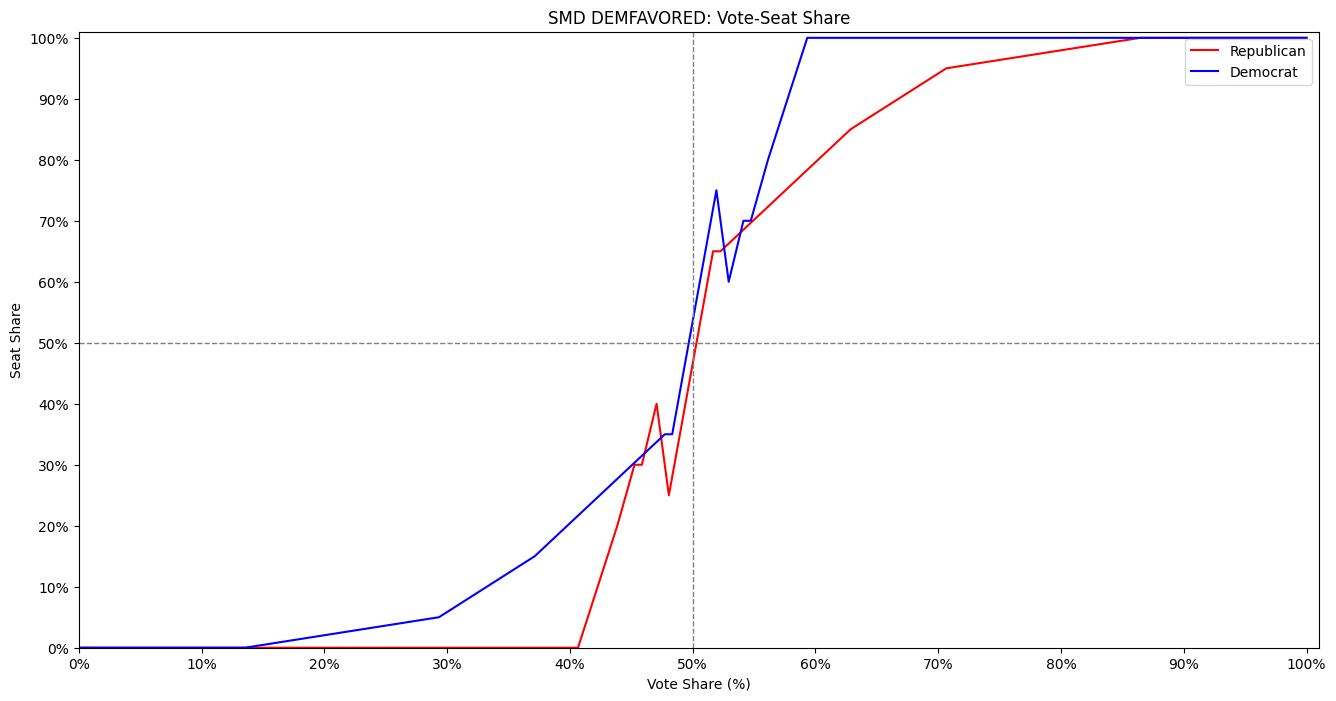

In [321]:


with open('nv_DEMFAVORED.json', 'r') as file:
    data = json.load(file)

random.seed(42)
plt.figure(figsize=(16, 8))

dem_df = pd.DataFrame([[0, 0], [1, 1]], columns = ['x', 'y'])
rep_df = pd.DataFrame([[0, 0], [1, 1]], columns = ['x', 'y'])

simulation = pd.DataFrame(data['curveData'])

total_dem_vote_share = (simulation['totalVotes'] * simulation['demVoteShare']).sum() / simulation['totalVotes'].sum()
total_dem_seat_share = (simulation['demVoteShare'] > 0.5).sum() / len(simulation)

dem_df.loc[len(dem_df)] = [total_dem_vote_share, total_dem_seat_share]
rep_df.loc[len(rep_df)] = [1 - total_dem_vote_share, 1 - total_dem_seat_share]

#simulation2 = simulation.copy()
# add the increment to dem vote share across districts
for i in range(50):
    dem_vote_share = simulation['demVoteShare']
    rep_vote_share = simulation['repVoteShare']
    totalVotes = simulation['totalVotes']

    dem_vote_shares = []
    dem_seat_shares = []
    increments = []
    for j in range(5):
        increment = 0.01 + random.randint(-5, 5) / 100
        increments.append(increment)

        tem_dem_vote_share = dem_vote_share
        tem_dem_vote_share += increment
        tem_dem_vote_share = np.clip(tem_dem_vote_share, 0, 1)

        dem_vote_shares.append((totalVotes * tem_dem_vote_share).sum() / totalVotes.sum())
        dem_seat_shares.append((tem_dem_vote_share > 0.5).sum() / len(simulation))
        
    avg_dem_vote_share = np.average(dem_vote_shares)
    avg_dem_seat_share = np.average(dem_seat_shares)

    simulation['demVoteShare'] += np.average(increments)
    simulation['repVoteShare'] -= np.average(increments)

    dem_df.loc[len(dem_df)] = [avg_dem_vote_share, avg_dem_seat_share]
    rep_df.loc[len(rep_df)] = [1 - avg_dem_vote_share, 1 - avg_dem_seat_share]


for i in range(50):
    dem_vote_share = simulation['demVoteShare']
    rep_vote_share = simulation['repVoteShare']
    totalVotes = simulation['totalVotes']

    dem_vote_shares = []
    dem_seat_shares = []
    increments = []
    for j in range(5):
        increment = -0.01 + random.randint(-5, 5) / 100
        increments.append(increment)

        tem_dem_vote_share = dem_vote_share
        tem_dem_vote_share += increment
        tem_dem_vote_share = np.clip(tem_dem_vote_share, 0, 1)

        dem_vote_shares.append((totalVotes * tem_dem_vote_share).sum() / totalVotes.sum())
        dem_seat_shares.append((tem_dem_vote_share > 0.5).sum() / len(simulation))
        
    avg_dem_vote_share = np.average(dem_vote_shares)
    avg_dem_seat_share = np.average(dem_seat_shares)

    simulation['demVoteShare'] += np.average(increments)
    simulation['repVoteShare'] -= np.average(increments)

    dem_df.loc[len(dem_df)] = [avg_dem_vote_share, avg_dem_seat_share]
    rep_df.loc[len(rep_df)] = [1 - avg_dem_vote_share, 1 - avg_dem_seat_share]

dem_df = dem_df.sort_values(by = 'x')
rep_df = rep_df.sort_values(by = 'x')

plt.plot(rep_df['x'], rep_df['y'], label = 'Republican', color = 'red')
plt.plot(dem_df['x'], dem_df['y'], label = 'Democrat', color = 'blue')

# Set the axis limits
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)

# Set the ticks to show percentages
tick_positions = np.arange(0, 1.1, 0.1)  # Positions for ticks (0% to 100%)
tick_labels = [f"{int(tick * 100)}%" for tick in tick_positions]  # Labels as percentages

plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)

# Labels and legend
plt.title(f'SMD {data["characteristic"]}: Vote-Seat Share')
plt.xlabel("Vote Share (%)")
plt.ylabel("Seat Share")
plt.legend()
plt.show()

In [28]:
#fix box and whisker
def collect_box_and_whisker_bins(data, json, races):

    total_bins = data["totalDistricts"]  # Total bins = total districts per plan

    # Initialize bins to hold percentages
    bins_dict = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}
    enacted_bins = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}

    # Step 1: Process each district plan
    for plan_index, plan in enumerate(data["barData"]):  
        # Step 2: Extract and sort race percentages within each district plan
        race_percentages = {race: [] for race in races}
        for district in plan["districts"]:  
            total_population = sum(district[race] for race in races)
            for race in races:
                percentage = (district[race] / total_population) * 100 if total_population > 0 else 0
                race_percentages[race].append(percentage)
        
        # Sort percentages for each race and distribute them into bins
        for race in races:
            sorted_percentages = sorted(race_percentages[race])
            for i, value in enumerate(sorted_percentages):
                bin_key = f"Bin {i + 1}"
                bins_dict[bin_key][race].append(value)
        
        # Step 3: Process enacted plan separately (first plan only)
        if plan_index == 0:  
            for race in races:
                sorted_enacted = sorted(race_percentages[race])
                for i, value in enumerate(sorted_enacted):
                    bin_key = f"Bin {i + 1}"
                    enacted_bins[bin_key][race].append(value)

    # Step 4: Calculate statistics for each bin
    json["boxes"] = []
    for bin_key, race_data in bins_dict.items():
        stats = {"bin": bin_key}
        for race, values in race_data.items():
            enacted_values = enacted_bins[bin_key][race]  # Enacted values for this bin and race
            values = np.array(values)
            if len(values) > 0:
                stats[race] = {
                    "min": float(np.min(values)),
                    "q1": float(np.percentile(values, 25)),
                    "median": float(np.median(values)),
                    "q3": float(np.percentile(values, 75)),
                    "max": float(np.max(values)),
                    "enactedValue": round(float(np.mean(enacted_values)), 2) if len(enacted_values) > 0 else 0
                }
            else:
                stats[race] = {"min": 0, "q1": 0, "median": 0, "q3": 0, "max": 0, "enactedValue": 0}
        json["boxes"].append(stats)

nv_box_and_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }
races = ["white", "black", "asian", "hispanic"]
collect_box_and_whisker_bins(nv_demographic_data, nv_box_and_whisker_data, races)
nv_box_and_whisker_data

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': 4,
 'boxes': [{'bin': 'Bin 1',
   'white': {'min': 47.0849166343544,
    'q1': 53.73265912051578,
    'median': 56.07725378704099,
    'q3': 57.99026304350483,
    'max': 62.03081975063709,
    'enactedValue': 56.13},
   'black': {'min': 6.327317145083504,
    'q1': 6.664924953415607,
    'median': 6.695025272328284,
    'q3': 6.932671114684961,
    'max': 8.524623595477674,
    'enactedValue': 6.7},
   'asian': {'min': 8.474122638671327,
    'q1': 9.611312396748826,
    'median': 9.747144918845182,
    'q3': 10.00432379601014,
    'max': 11.770136937152424,
    'enactedValue': 9.75},
   'hispanic': {'min': 1.4416852171542796,
    'q1': 1.5065732834073917,
    'median': 1.519469907148082,
    'q3': 1.5598788475336933,
    'max': 1.8323540791722506,
    'enactedValue': 1.52}},
  {'bin': 'Bin 2',
   'white': {'min': 53.35445224424179,
    'q1': 60.84388165733519,
    'median': 62.179572285305056,
    'q3': 63.392821063537454,
    

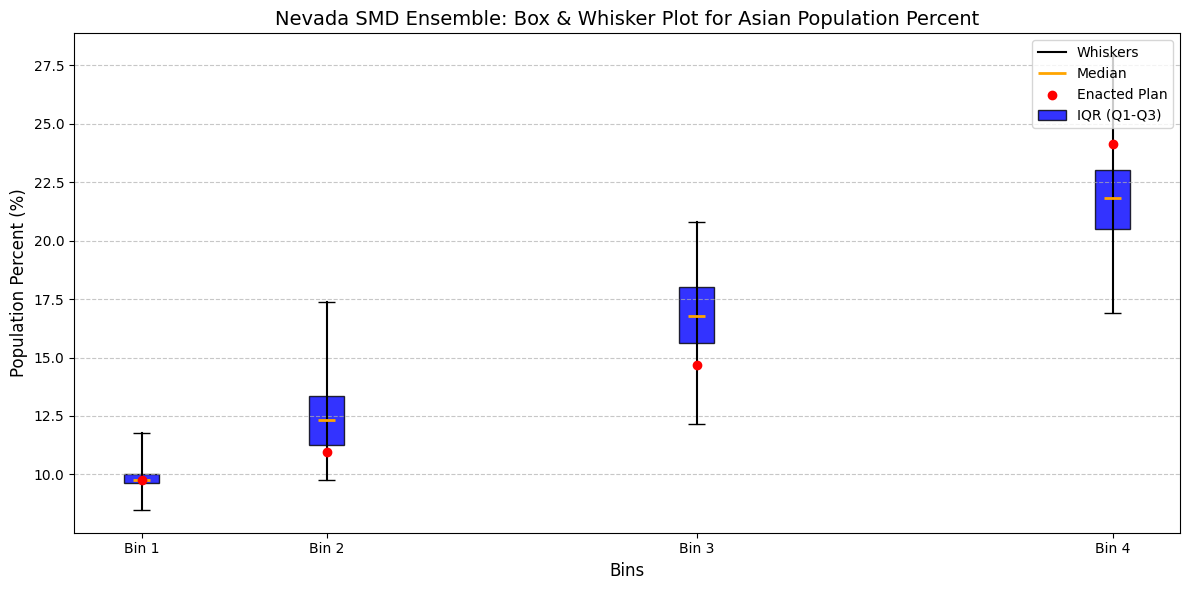

In [35]:
def ensembles_box_and_whisker_plot(data, comparison_basis):
    """
    Constructs a box-and-whisker plot where bins represent sorted percentage ranges for a demographic,
    and each bin starts after the previous max value. Enacted values are added as red dots.

    Args:
        data (dict): Input data containing box statistics and binned data.
        comparison_basis (str): Demographic basis to analyze (e.g., "white", "hispanic").
    """
    # Extract bins and their statistics for the selected comparison_basis
    sorted_boxes = data["boxes"]  # No need to sort explicitly since bins are sequential
    bins = [box["bin"] for box in sorted_boxes]  # Bin labels

    # Extract statistics
    min_values = [box[comparison_basis]["min"] for box in sorted_boxes]
    q1_values = [box[comparison_basis]["q1"] for box in sorted_boxes]
    median_values = [box[comparison_basis]["median"] for box in sorted_boxes]
    q3_values = [box[comparison_basis]["q3"] for box in sorted_boxes]
    max_values = [box[comparison_basis]["max"] for box in sorted_boxes]
    enacted_values = [box[comparison_basis]["enactedValue"] for box in sorted_boxes]

    # Adjust x-positions so each box starts after the previous box's max
    x_positions = [0]  # Initialize the first box position
    for i in range(1, len(max_values)):
        x_positions.append(x_positions[-1] + max_values[i-1] - min_values[i-1] + 1)  # Add space after the previous max

    # Plot
    plt.figure(figsize=(12, 6))

    for i, (x, min_val, q1, median, q3, max_val, enacted_val) in enumerate(
        zip(x_positions, min_values, q1_values, median_values, q3_values, max_values, enacted_values)
    ):
        # Whiskers
        plt.plot([x, x], [min_val, max_val], color='black', zorder=2, label="Whiskers" if i == 0 else "")
        plt.hlines(min_val, x - 0.2, x + 0.2, color='black', linewidth=1)  # Min line
        plt.hlines(max_val, x - 0.2, x + 0.2, color='black', linewidth=1)  # Max line

        # Box (Q1 to Q3)
        plt.bar(
            x, q3 - q1, bottom=q1, width=0.8, color='blue', alpha=0.8,
            edgecolor='black', zorder=1, label="IQR (Q1-Q3)" if i == 0 else ""
        )

        # Median
        plt.hlines(median, x - 0.2, x + 0.2, color='orange', linewidth=2, label="Median" if i == 0 else "")

        # Enacted Value
        plt.scatter(x, enacted_val, color='red', zorder=3, label="Enacted Plan" if i == 0 else "")

    # Add x-axis labels
    plt.xticks(x_positions, bins, rotation=0)
    # Add title and axis labels
    plt.title(f"Nevada SMD Ensemble: Box & Whisker Plot for {comparison_basis.capitalize()} Population Percent", fontsize=14)
    plt.xlabel("Bins", fontsize=12)
    plt.ylabel("Population Percent (%)", fontsize=12)
    # Add legend
    plt.legend(loc="upper right")
    # Add gridlines for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()
ensembles_box_and_whisker_plot(nv_box_and_whisker_data, 'asian')

In [216]:
def ensemble_smd_data_output(fips,shapefile,ensemble_data_paths,plan_specific_data_paths ,minority='black',opportunity_threshold=0.20, election_type='SMD'):
    races = ["white", "black", "asian", "hispanic", "other"]
    smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]
    
    demographic_data = {
    "fips": fips,
    "electionType": election_type,
    "totalDistricts": 0,
    "barData": []
    }
    state_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }
    #load data 

    for ensemble_file_path in ensemble_data_paths:
        with open(ensemble_file_path, 'r') as file:
            smd_ensemble = json.load(file)
            collect_district_plan_demographic(smd_ensemble, shapefile ,demographic_data)
            election_result_collection(smd_ensemble, state_data)

    calculate_opportunity(demographic_data, state_data, 'black', 0.20)



    box_and_whisker_data = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "boxes": []

        }

    collect_box_and_whisker_bins(demographic_data, box_and_whisker_data, races) 

    
    smd_interesting_plan_data = []

    #load specific plan data data
    for plan_specific_file_path in plan_specific_data_paths:
        with open(plan_specific_file_path, 'r') as file:
            smd_plan_specific = json.load(file)
            smd_interesting_plan_data.append(smd_plan_specific)

    for plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):
        plan_specific_data = {
            "fips": "NV",
            "electionType": "SMD",
            "totalDistricts": 4,
            "characteristic": plan_name,
            "demTotalVotes": 0,
            "repTotalVotes": 0,
            "districts": []
            }
        collec_metrics_plan_specific(plan_data, plan_specific_data, plan_name)
   


        plan_specific = {
            "fips": "NV",
            "electionType": "SMD",
            "totalDistricts": 4,
            "characteristic": plan_name,
            "democratsSeats": 0,
            "republicanSeats": 0,
            "demTotalVotes": 0,
            "repTotalVotes": 0,
            "bias": 0,
            "symmetry": 0,
            "responsiveness": 0,
            "curveData": []
            }
    vote_seat_share_data_collectiotion_specific_plan( plan_specific_data ,plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'Nevada/smd_plan_specific/nv_smd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(plan_specific, json_file, indent=4)



    return state_data, box_and_whisker_data




Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'VTDST', 'NAME', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREIBLA', 'G20PREONON', 'STATEFP20',
       'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'GEOID', 'ADJPOP',
       'TAWHITEALN', 'TABLACKCMB', 'TAAIANCMB', 'TAASIANCMB', 'TANHOPICMB',
       'TAOTHERALN', 'TA2RACE', 'TAHISPANIC', 'RACPOP_SUM', 'SCALING_FA',
       'WHT', 'AFAM', 'AIAN', 'ASN', 'HPAC', 'OTHR', 'LAT', 'geometry'],
      dtype='object')